In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

## Open data

In [140]:
df_T = pd.read_csv('../data/final/temperature.csv', index_col=0)
df_T['total'] = df_T['Annual']

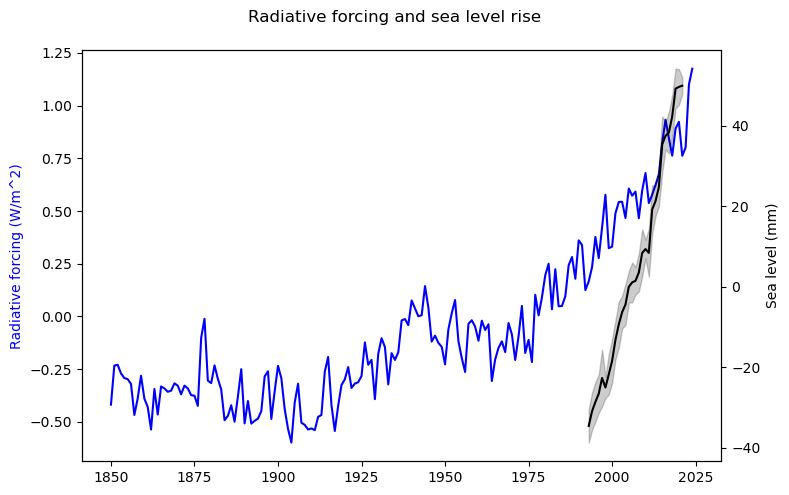

In [251]:
# df_F = pd.read_csv('../data/final/forcing_all.csv', index_col=0)[800:]
df_F = df_T
df_S = pd.read_csv('../data/final/processed_sea_level_data.csv', index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax2 = ax.twinx()
ax.plot(df_F.index, df_F['total'], color='blue', label='CO2')
ax.set_ylabel('Radiative forcing (W/m^2)', color='blue')

ax2.plot(df_S.index, df_S['GMSL_noGIA'], color='black', label='Sea level')
ax2.fill_between(df_S.index, df_S['GMSL_noGIA'] - df_S['uncertainty'], df_S['GMSL_noGIA'] + df_S['uncertainty'], color='black', alpha=0.2)
ax2.set_ylabel('Sea level (mm)', color='black')

fig.suptitle('Radiative forcing and sea level rise')
fig.tight_layout()
fig.subplots_adjust(top=0.9)



    

In [253]:
class Aligner:
    def __init__(self, df_1, df_2):
        self.df_1 = df_1
        self.df_2 = df_2

        # both of these dataframes have years on the index
        # we want to use this class to get two numpy arrays containing the indices of the years that are common to both dataframes
        self.get_idx()

    def get_idx(self):
        self.common_years = np.intersect1d(self.df_1.index, self.df_2.index)
        self.idx_1 = self.df_1.index.isin(self.common_years)
        self.idx_2 = self.df_2.index.isin(self.common_years)

    def align(self, df):
        return df.loc[self.common_years]

aligner = Aligner(df_F, df_S)
aligner.align(df_F)

,Annual,Annual_uncertainty,total
Year,,,
1993.0,0.166,0.071344,0.166
1994.0,0.234,0.087598,0.234
1995.0,0.377,0.108436,0.377
1996.0,0.277,0.083012,0.277
1997.0,0.422,0.108372,0.422
1998.0,0.577,0.119545,0.577
1999.0,0.324,0.091043,0.324
2000.0,0.331,0.112712,0.331
2001.0,0.489,0.078805,0.489


## Build model

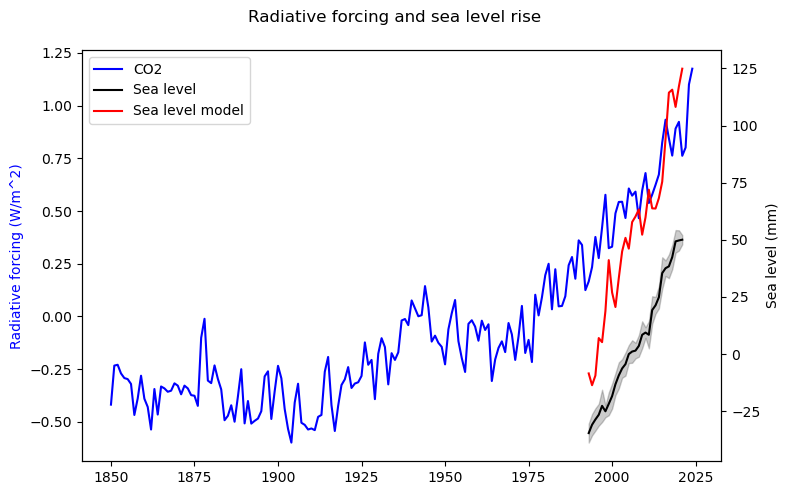

In [267]:
def get_S(T, S_0, tau2, a2, b2):
    # Calculate equilibrium sea level
    
    S_eq = a2 * T + b2

    # Initialize S
    S = np.zeros(len(T))
    S[0] = S_0
    for i in range(1, len(T)):
        S[i] = S[i-1] + ((S_eq[i-1] - S[i-1]) / tau2)
    return S
T = df_F['total'].values

S = get_S(T, -200, 2, 200, -52)
df_S_model = pd.DataFrame({'GMSL_noGIA': S}, index=df_F.index)
aligner = Aligner(df_S_model, df_S)
S = aligner.align(df_S_model)


fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax2 = ax.twinx()
ax.plot(df_F.index, df_F['total'], color='blue', label='CO2')
ax.set_ylabel('Radiative forcing (W/m^2)', color='blue')

ax2.plot(df_S.index, df_S['GMSL_noGIA'], color='black', label='Sea level')
ax2.fill_between(df_S.index, df_S['GMSL_noGIA'] - df_S['uncertainty'], df_S['GMSL_noGIA'] + df_S['uncertainty'], color='black', alpha=0.2)
ax2.set_ylabel('Sea level (mm)', color='black')

ax2.plot(df_S.index, S, color='red', label='Sea level model')

fig.suptitle('Radiative forcing and sea level rise')
# combine legends
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)


fig.tight_layout()
fig.subplots_adjust(top=0.9)

## Define prior, likelihood and probability

In [268]:
# Define the log prior function
def log_prior(theta):
    S_0, tau2, a2, b2 = theta
    
    cond5 = -2000 < S_0 < 1500
    cond6 = 1 < tau2 < 700
    cond7 = -200 < a2 < 900
    cond8 = -100 < b2 < 200

    if cond5 and cond6 and cond7 and cond8:
        return 0.0  # Uniform prior (log probability is zero within bounds)
    return -np.inf  # Log probability is -infinity outside bounds

# Define the log likelihood function
def log_likelihood(theta, F, S_obs, sigma):

    S_0, tau2, a2, b2 = theta

    # T = get_T(F.values, T_0, tau1, a1, b1)
    S_model = get_S(F.values, S_0, tau2, a2, b2)

    # align times of F and S
    df_S_model = pd.DataFrame({'GMSL_noGIA': S_model}, index=df_F.index)
    aligner = Aligner(df_S_model, df_S)
    S_model = aligner.align(df_S_model)

    y, y_pred, sig = S_obs.values.flatten(), S_model.values.flatten(), sigma.values.flatten()
    # print(y)
    # print(y_pred)
    # print(sig)

    # # Compute the log likelihood assuming Gaussian errors
    # return -0.5 * np.sum(((S_obs - S_model) / sigma)**2 + np.log(2 * np.pi * sigma**2))
    return -0.5 * np.sum(((y - y_pred) / sig)**2 + np.log(2 * np.pi * sig**2))

# Define the full log probability function
def log_probability(theta, F, S_obs, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, F, S_obs, sigma)

# try log likelihood
theta = [-10, 2, 3, -51]
log_probability(theta, df_F['total'], df_S['GMSL_noGIA'], df_S['uncertainty'])

-3723.4227866293313

## MCMC

In [ ]:
initial = [ -200, 2, 200, -52]


# Set up the MCMC sampler
ndim = len(initial)  # Number of parameters
nwalkers = 64  # Number of MCMC walkers
# Initialize the walkers in a small Gaussian ball around the initial guess
pos = initial + 1e+1 * np.random.randn(nwalkers, ndim)

# Run MCMC using emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=( df_F['total'], df_S['GMSL_noGIA'], df_S['uncertainty']))

# Burn-in phase
print("Running burn-in...")
sampler.run_mcmc(pos, 25500, progress=True)
sampler.reset()

# Production run
print("Running production...")
sampler.run_mcmc(None, 5000, progress=True)

# Extract the samples
samples = sampler.get_chain(flat=True)

# Plot posterior distributions
fig = corner.corner(samples, labels=["S_0", "tau2", "a2", "b2"],
                    truths=initial)
plt.show()

# Compute the mean and uncertainties of the parameters
from IPython.display import display, Math
import scipy.stats as stats

param_names = ["S_0", "tau2", "a2", "b2"]
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{0} = {1:.3f} (+{2:.3f}, -{3:.3f})".format(param_names[i], mcmc[1], q[1], q[0])
    print(txt)

Running burn-in...


 17%|█▋        | 4360/25500 [00:38<03:06, 113.64it/s]

## Plot best fit

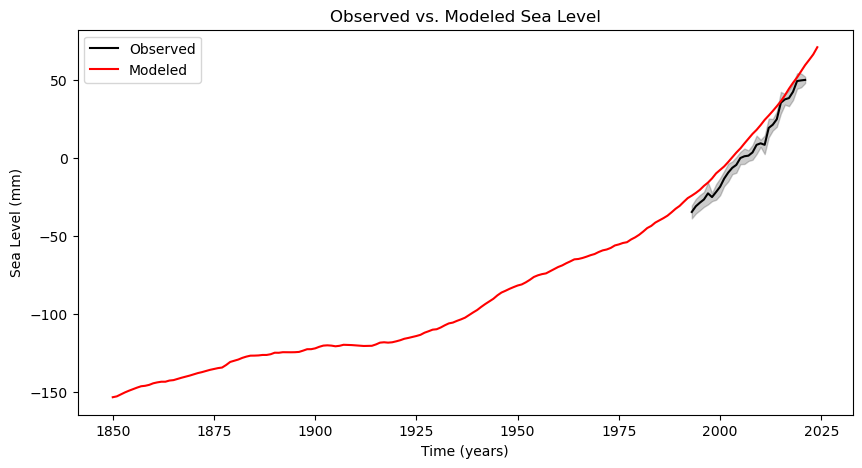

In [270]:
# Use the median parameters to compute the modeled sea level
best_params = np.median(samples, axis=0)

# ["T_0", "tau1", "a1", "b1", "S_0", "tau2", "a2", "b2"]
# a_best, b_best, S_0_best, tau_best, k_best, s_best = best_params
S_0_best, tau2_best, a2_best, b2_best = best_params

S_model_full = get_S(df_F['total'].values, S_0_best, tau2_best, a2_best, b2_best)

# Plot the observed vs. modeled sea level
plt.figure(figsize=(10, 5))
plt.plot(df_S.index, df_S['GMSL_noGIA'], color='black', label='Observed')
plt.fill_between(df_S.index, df_S['GMSL_noGIA'] - df_S['uncertainty'], df_S['GMSL_noGIA'] + df_S['uncertainty'], color='black', alpha=0.2)
plt.plot(df_F.index, S_model_full, color='red', label='Modeled')

plt.xlabel('Time (years)')
plt.ylabel('Sea Level (mm)')
plt.title('Observed vs. Modeled Sea Level')
plt.legend()
plt.show()

# Plot many samples

100%|██████████| 200/200 [00:00<00:00, 2463.72it/s]


{'allowed': 200, 'rejected': 0}


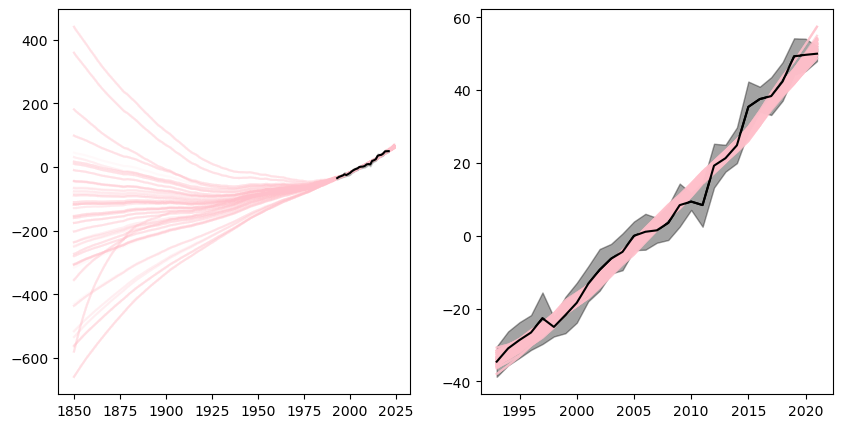

In [282]:
# show many samples
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
def S_allowed(S_model, S_obs, sigma):
    # print(f'S_model: {S_model}')
    # print(f'S_obs: {S_obs}')
    # print(f'sigma: {sigma}')

    return (np.abs(S_model-S_obs) < sigma*5.0).all()

plt.plot(df_S.index, df_S['GMSL_noGIA'], color='black', label='Observed')
plt.fill_between(df_S.index, df_S['GMSL_noGIA'] - df_S['uncertainty'], df_S['GMSL_noGIA'] + df_S['uncertainty'], color='black', alpha=0.2)

time = df_F.index
timeo = df_S.index
# S_obs = df_S['GMSL_noGIA']
# sigma = df_S['uncertainty']

aligner = Aligner(df_F, df_S)

decision = {
    'allowed': 0,
    'rejected': 0
}
from tqdm import tqdm
for i in tqdm(range(200)):
    # Use the median parameters to compute the modeled sea level
    params = samples[-i]
    # S_model_full = np.cumsum(get_dS(T, *params))
    S_model_full = get_S(T, *params)
    # print(len(S_model_full))
    
    S_model = aligner.align(pd.DataFrame({'GMSL_noGIA': S_model_full}, index=df_F.index))
    
    # print(len(S_model_full))

    sm = S_model.values.flatten()
    so = df_S['GMSL_noGIA'].values.flatten()
    sigma = df_S['uncertainty'].values.flatten()


    if S_allowed(sm, so, sigma):
        decision['allowed'] += 1
        # Plot the observed vs. modeled sea level
        ax[0].plot(time, S_model_full, color='pink', alpha=.09)
        ax[1].plot(timeo, sm, color='pink', alpha=.3)
    else:
        decision['rejected'] += 1


for axi in ax:
    axi.plot(df_S.index, df_S['GMSL_noGIA'], color='black', label='Observed')
    axi.fill_between(df_S.index, df_S['GMSL_noGIA'] - df_S['uncertainty'], df_S['GMSL_noGIA'] + df_S['uncertainty'], color='black', alpha=0.2)

print(decision)


#     # plt.plot(time, S_model_full, color='red', alpha=0.01)
# print(decision)
# # observed sea level
# # Add uncertainty bounds
# for i in range(2):
#     # ax[i].plot(time[143:-103], df_S['GMSL_noGIA'], label='Observed Sea Level', color='green')
#     for j in range(1,4):
#         ax[i].fill_between(time[143:-103], df_S['GMSL_noGIA'], df_S['GMSL_noGIA'] + sigma*j, color='blue', alpha=0.3)
#         ax[i].fill_between(time[143:-103], df_S['GMSL_noGIA'], df_S['GMSL_noGIA'] - sigma*j, color='red', alpha=0.3)



# Add uncertainty bounds

for axis in ax:
    axis.set_xlabel('Time (years)')
    axis.set_ylabel('Sea Level (mm)')
    axis.set_title('Observed vs. Modeled Sea Level')
    axis.legend()
plt.tight_layout()
plt.show()
